# SRP-PHAT algorithm

In this notebook, we perform TDOA esimaton using the GCC-PHAT. We then use the Steered Response Power Phase Transform algorithm to perform sound source localization.

Given two signals $ x_{i}(n)$ and $ x_{j}(n)$ the GCC-PHAT is defined as:

$\displaystyle \hat{G}_{PHAT}(f) = \frac{X_{i}(f) [X_{j}(f)]^{*}}{\vert X_{i}(f) [X_{j}(f)]^{*}\vert}$, where $ X_{i}(f)$ and $ X_{j}(f)$ are the Fourier transforms of the two signals and $ [\ ]^{*}$ denotes the complex conjugate.

The TDOA for these two microphones is estimated as:

 $\displaystyle \hat{d}_{PHAT}(i,j) = {arg max \atop d} \big(\hat{R}_{PHAT}(d)\big)$, where $ \hat{R}_{PHAT}(d)$ is the inverse Fourier transform of the above function.

*References* : [Microphone arrays : signal processing techniques and applications, Chapter 8 (Robust Localization in Reverberant Rooms)](https://beast-epfl.hosted.exlibrisgroup.com/primo-explore/fulldisplay?docid=TN_ebi01_prod004161025&context=P2P&vid=EPFL&lang=fr_FR&search_scope=default_scope&adaptor=Primo2Primo_41EPFL&tab=default_tab&query=any,contains,microphone%20array%20signal%20processing&sortby=rank&offset=0)

1. [Room setup & GCC-PHAT](#gcc)
2. [SRP-PHAT](#srp)
3. [Visualization of results](#vie)

In [27]:
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt
from scipy.io import wavfile
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import math, random
from helpers_srp import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='gcc'></a>
### 1. Room setup and GCC-PHAT

Create room setup

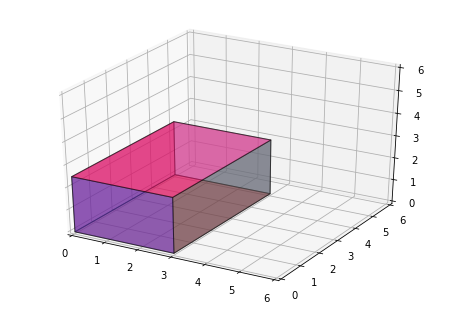

In [28]:
#Room dimensions
room_dimX, room_dimY, room_dimZ = 3, 5, 2.5
room_dim = np.array([room_dimX, room_dimY, room_dimZ])

#Sampling frequency
fs = 16000 # 16kHz

room = pra.ShoeBox(room_dim, fs=fs, max_order = 4, absorption=0.2)

# Visualize setup
fig, ax = room.plot()
ax.set_xlim([0, 6])
ax.set_ylim([0, 6])
ax.set_zlim([0, 6]);

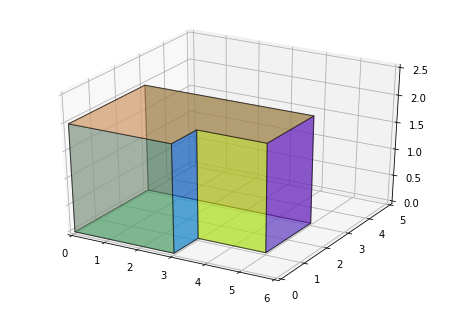

In [146]:
# Create a 3D L-Shaped room 
corners = np.array([[0, 0], [0, 3], [5, 3], [5, 1], [3, 1], [3, 0]]).T # [x, y]
room = pra.Room.from_corners(corners, fs=fs, max_order= 4, absorption=0.2)
room.extrude(2.)
# Visualize setup
fig, ax = room.plot()
ax.set_xlim([0, 6])
ax.set_ylim([0, 5])
ax.set_zlim([0, 2.5]);

Create and visualize microphone array

In [110]:
radius = 0.1
points = sphere_micsArray(5, [4*2, 2*2, 2*1], radius=radius)

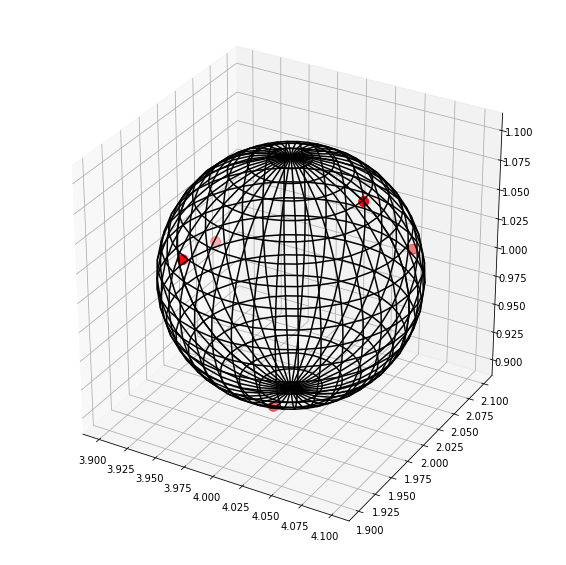

In [111]:
#Visualize what our mic array looks like
phi = np.linspace(0, np.pi, 20)
theta = np.linspace(0, 2 * np.pi, 40)

x = np.outer(np.sin(theta), np.cos(phi))
y = np.outer(np.sin(theta), np.sin(phi))
z = np.outer(np.cos(theta), np.ones_like(phi))

norm = np.sqrt(x**2 + y**2 + z**2)
x /= (1/radius)*norm
y /= (1/radius)*norm
z /= (1/radius)*norm

fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d', 'aspect':'equal'})
fig.set_size_inches(10,10,10)
#ax.plot_wireframe(x + room_dim[0]/2, y + room_dim[1]/2, z + room_dim[2]/2, color='k', rstride=1, cstride=1)
ax.plot_wireframe(x + 4, y + 2, z + 1, color='k', rstride=1, cstride=1)
ax.scatter(points[:,0], points[:,1], points[:,2], s=100, c='r', zorder=10)

Add mic array to our room setup

In [140]:
# the fs of the microphones is the same as the room
mic_array = pra.MicrophoneArray(points.T, room.fs)

room.add_microphone_array(mic_array)

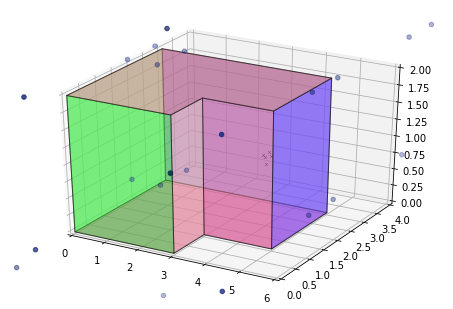

In [141]:
fig, ax = room.plot()
ax.set_xlim([0, 6])
ax.set_ylim([0, 4])
ax.set_zlim([0, 2]);

Add source to our room

In [114]:
# Add source of 5 seconds duration 
rng = np.random.RandomState(23)
duration_samples = 5*int(fs) 
source_signal = rng.randn(duration_samples)

theta_gt = (45*np.pi)/180
phi_gt = (60*np.pi)/180
#source_location = (room_dim/2) + spherical_to_cartesian(r=1, theta=theta_gt, phi=phi_gt)

mic_position = np.array([4, 2, 1])
source_pos = np.array([2.5, 0.5, 1])

diff_vec = mic_position - source_pos
r, theta_gt, phi_gt = cartesian_to_spherical(diff_vec[0], diff_vec[1], diff_vec[2])


source_location = mic_position - spherical_to_cartesian(r, theta_gt, phi_gt)

room.add_source(source_location, signal=source_signal)

room.image_source_model(use_libroom=False)
room.compute_rir()

rir = room.rir

Plot the RIR between mic 0 and source

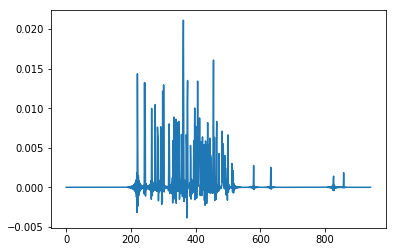

In [116]:
plt.plot(room.rir[0][0])
plt.show()

Simulate sound propagation

In [117]:
room.simulate()

Plot signal at microphone 0

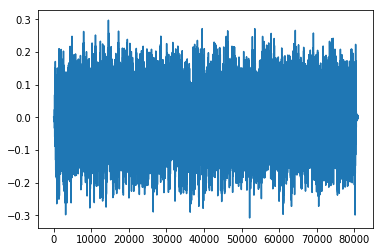

In [118]:
plt.plot(room.mic_array.signals[0,:])

**Perform TDOA estimation**

In [119]:
sound_speed = 343.2
#max_tau = distance/sound_speed
tau, cc = gcc_phat(room.mic_array.signals[0,:], room.mic_array.signals[1,:], fs=fs)

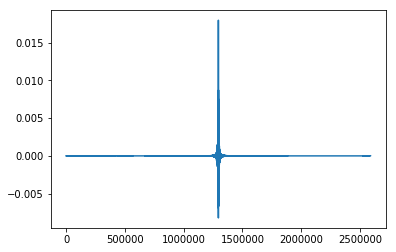

In [120]:
plt.plot(cc)

In [121]:
print("TDOA between the 2 microphone is: {tdoa}s".format(tdoa=abs(tau)))

TDOA between the 2 microphone is: 0.00126953125s


<a id='srp'></a>
### 2. SRP PHAT

In [134]:
nfft = 256  # FFT size
freq_range = [300, 3500]
srp = pra.doa.srp.SRP(points.T, fs, nfft, mode='near' ,dim=3, num_src=1)

The DOA algorithms require an STFT input, which we will compute for overlapping frames for our 1 second duration signal.

In [135]:
X = np.array([pra.stft(signal, nfft, nfft // 2, transform=np.fft.rfft).T for signal in room.mic_array.signals])

In [136]:
srp.locate_sources(X, freq_range=freq_range)

In [137]:
phi_recon = srp.azimuth_recon[0]
theta_recon = srp.colatitude_recon[0]

<a id='vie'></a>
### 3. Visualization of results

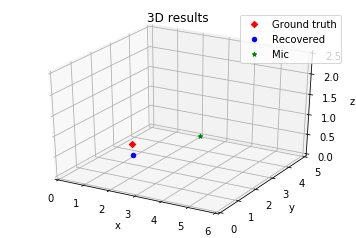

In [138]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim(0,6)
ax.set_ylim(0,5)
a = ax.set_zlim(0,2.5)

gt_X, gt_Y, gt_Z = source_location[0], source_location[1], source_location[2]

sca1 = ax.scatter3D(gt_X, gt_Y, gt_Z, c='r', marker='D');

#recon_X, recon_Y, recon_Z = room_dim/2 + spherical_to_cartesian(r=, theta_recon, phi_recon)

recon_X, recon_Y, recon_Z = mic_position + spherical_to_cartesian(r, theta_recon, phi_recon)
sca2 = ax.scatter3D(recon_X, recon_Y, recon_Z, c='b', marker='o', depthshade=False)

#sca3 = ax.scatter3D(room_dimX/2, room_dimY/2, room_dimZ/2, c='g', marker='*');
sca3 = ax.scatter3D(mic_position[0], mic_position[1], mic_position[2], c='g', marker='*');

plt.legend((sca1, sca2, sca3), ('Ground truth', 'Recovered', 'Mic'), loc=0)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.title('3D results')
plt.show()

In [139]:
print('L2 Distance between ground truth position and recovered postion is: {pos} cm'.format(pos=100*np.linalg.norm(np.array([gt_X, gt_Y, gt_Z]) - np.array([recon_X, recon_Y, recon_Z]))))

L2 Distance between ground truth position and recovered postion is: 57.11079834650721 cm
